In [25]:
import os 
import numpy as np
from util import plot_figure
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.ticker import ScalarFormatter
import seaborn as sns
matplotlib.rcParams['ps.useafm'] = True
matplotlib.rcParams['pdf.use14corefonts'] = True
color_list = sns.color_palette()
from util import compute_spectral_gap

### Check Details

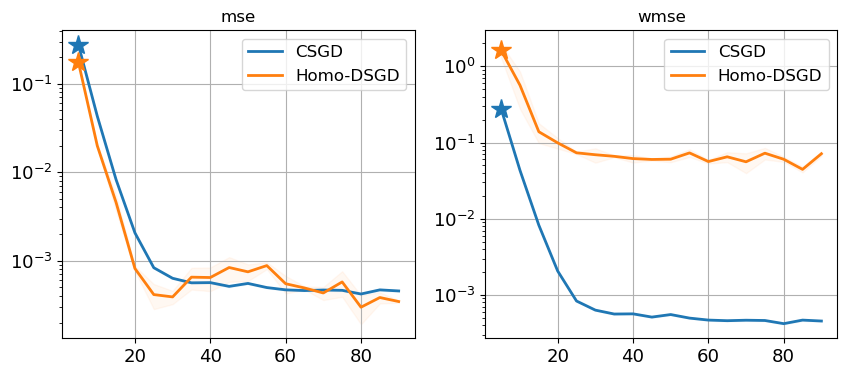

In [26]:
num_agent = 45
# 20, 30, 40, 50
fig, ax = plt.subplots(1, 2, figsize=(5*2, 4))

def subplot(me, ax, fig_idx ):

    plot_csgd = plot_figure(algo_name=f'csgd', sub_sample=1, dir=f'./s2_res/NumAgent{num_agent}/', log_flag=False, metric='mse')
    plot_csgd.plot_lines(ax[fig_idx], color_list[0], label='CSGD', legend=True, plot_star=True)

    plot_dsgd_homo = plot_figure(algo_name=f'dsgd-homo', sub_sample=1, dir=f'./s2_res/NumAgent{num_agent}/', log_flag=False, metric=me)
    plot_dsgd_homo.plot_lines(ax[fig_idx], color_list[1], label='Homo-DSGD', legend=True, plot_star=True,)

    if num_agent <= 20:
        plot_dsgd_hete = plot_figure(algo_name=f'dsgd-hete', sub_sample=1, dir=f'./s2_res/NumAgent{num_agent}/', log_flag=False, metric=me)
        plot_dsgd_hete.plot_lines(ax[fig_idx], color_list[2], label='Hete-DSGD', legend=True, plot_star=True,)
    ax[fig_idx].grid(True)
    ax[fig_idx].set_title(f'{me}')

subplot('mse',  ax=ax, fig_idx=0)
subplot('wmse', ax=ax, fig_idx=1)

plt.grid(True)

## Compute Transient time

In [27]:
def load_data(dir, word):
    file = [f for f in os.listdir(dir) if word in f]
    files = [np.load(os.path.join(dir, f), allow_pickle=True) for f in file]
    res = np.array([f.item().get('wmse') for f in files])
    xvals = files[0].item().get('iter')
    mean_res = np.mean(res, axis=0)
    return xvals, mean_res

def find_window(data, window_size, threshold):
    start_index = 0
    while start_index + window_size <= len(data):
        window = data[start_index:start_index+window_size]
        count = np.sum(window < threshold)
        if count >= window_size * 0.8:
            return start_index + window_size - 1
        start_index += 1
    return None


num_agent_list = [5, 10, 15, 20, 25, 30, 35, 40]
xvals = []
tran_time_list = []
tran_time_list_hete = []
graph = 'StarGraph'
window_size = 10

for num_agent in num_agent_list:
    # Get sqrt(n)/rho
    file_name = f's2_mixMat/' + f'MixingMat-{graph}-NumAgent{num_agent}.npy'
    W = np.load(file_name)
    spectral_gap = compute_spectral_gap(W)
    if spectral_gap.imag == 0:
        spectral_gap = spectral_gap.real
    
    xvals.append(np.sqrt(num_agent)/spectral_gap)
    # xvals.append(np.sqrt(num_agent))

    # Get tran time
    parent_path = f'./s2_res/NumAgent{num_agent}'
    x_csgd, y_csgd = load_data(parent_path, 'csgd')
    keyword_dsgd = f'dsgd-homo-{graph}'
    _, y_dsgd = load_data(parent_path, keyword_dsgd)

    ratio = y_dsgd / y_csgd
    index = find_window(ratio, window_size, 2)
    if index is None:
        raise ValueError(f'Num Agent:{num_agent} No transient time found')
    tran_time = x_csgd[index]
    tran_time_list.append(tran_time)

    ## get transient time for hete
    if num_agent < 25:
        keyword_dsgd = f'dsgd-hete-{graph}'
        _, y_dsgd = load_data(parent_path, keyword_dsgd)

        ratio = y_dsgd / y_csgd
        index = find_window(ratio, window_size, 2)
        if index is None:
            # raise ValueError(f'Num Agent:{num_agent} No transient time found')
            tran_time_list_hete.append(None)
        else:
            tran_time = x_csgd[index]
            tran_time_list_hete.append(tran_time)
    else:
        tran_time_list_hete.append(None)

Text(0, 0.5, '$T_{cvx}$')

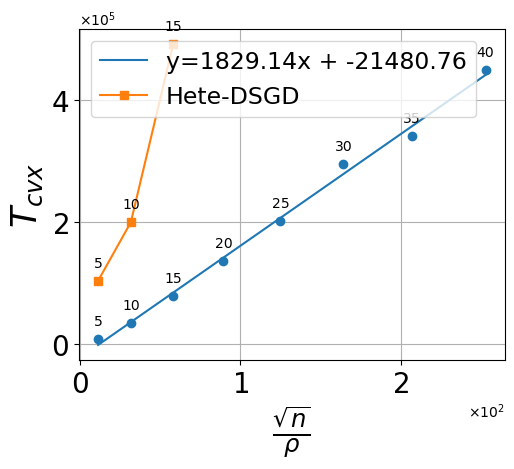

In [28]:
fig, ax = plt.subplots(figsize=(5.5,4.3))  # 设置图片大小为 8x6

coefficients = np.polyfit(xvals, tran_time_list, 1)
linear_fit = np.poly1d(coefficients)
ax.plot(xvals, tran_time_list, 'o', color=color_list[0],  markersize=6)
ax.plot(xvals, linear_fit(xvals), '-', label=f'y={coefficients[0]:.2f}x + {coefficients[1]:.2f}', color=color_list[0])

ax.plot(xvals, tran_time_list_hete, label=r'Hete-DSGD', color=color_list[1], marker='s', markersize=6, linestyle='-')

# Change x and y axis to scientific notation
ax.xaxis.set_major_formatter(ScalarFormatter(useMathText=True))
ax.yaxis.set_major_formatter(ScalarFormatter(useMathText=True))
# Annotate each point with the corresponding label
for i in range(len(xvals)):
    plt.annotate(f'{num_agent_list[i]}', (xvals[i], tran_time_list[i]), textcoords="offset points", xytext=(0,10), ha='center')
for i in range(len(xvals)):
    if tran_time_list_hete[i] is not None:
        plt.annotate(f'{num_agent_list[i]}', (xvals[i], tran_time_list_hete[i]), textcoords="offset points", xytext=(0,10), ha='center')

# Optionally, you can control the number of significant digits
ax.ticklabel_format(style='sci', axis='x', scilimits=(0,0))
ax.ticklabel_format(style='sci', axis='y', scilimits=(0,0))
# plt.xscale('log')
# plt.yscale('log')
ax.tick_params(axis='x', labelsize=20)
ax.tick_params(axis='y', labelsize=20)
plt.legend(loc=2, prop={'size': 17})
plt.grid()
plt.xlabel(r'$\frac{\sqrt{n}}{\rho}$', fontsize = 25)
plt.ylabel(r'$T_{cvx}$', fontsize = 25)